# Introduction to Artificial Neural Networks with Keras

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Perceptrons

In [2]:
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris['data'][:, (2,3)] #petal length, petal width
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(random_state=42) #per_cf means perceptron classifier
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

In [3]:
y_pred

array([1])

Saving figure perceptron_iris_plot


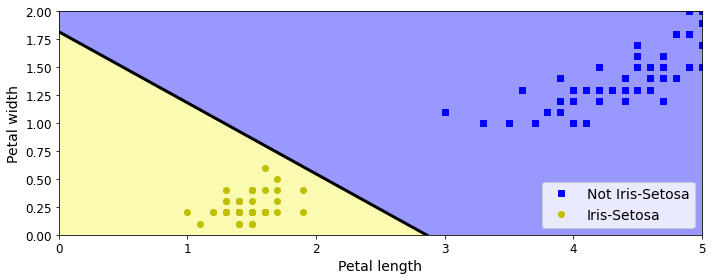

In [4]:
axes = [0, 5, 0, 2]

a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")
plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], 'k-', linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

save_fig("perceptron_iris_plot")
plt.show()

# Activation functions

In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z+eps) - f(z-eps)) / (2 * eps)

Saving figure activation_functions_plot


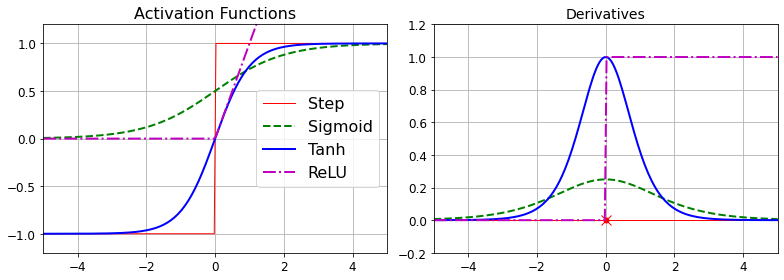

In [6]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(z, np.sign(z), 'r-', linewidth=1, label="Step")
plt.plot(z, sigmoid(z), 'g--', linewidth=2, label='Sigmoid')
plt.plot(z, np.tanh(z), 'b-', linewidth=2, label='Tanh')
plt.plot(z, relu(z), 'm-.', linewidth=2, label='ReLU')
plt.grid(True)
plt.legend(loc="center right", fontsize=16)
plt.title("Activation Functions", fontsize=16)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), 'r-', linewidth=1, label='Step')
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

In [7]:
def heaviside(z):
    return (z >=0 ).astype(z.dtype)

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

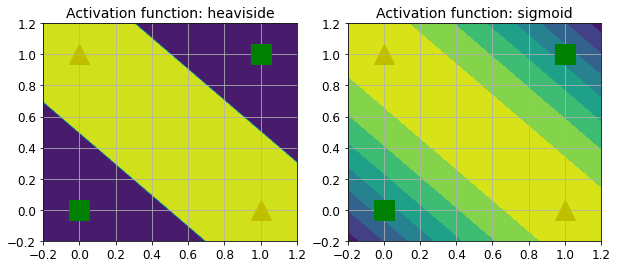

In [8]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

# Building an Image Classifier

In [9]:
import tensorflow as tf
from tensorflow import keras

In [10]:
tf.__version__

'2.4.1'

In [11]:
keras.__version__

'2.4.0'

In [12]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

The training set contains 60,000 grayscale images, each 28 * 28 pixels:

In [13]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is represented by a byte (0 to 255)

In [14]:
X_train_full.dtype

dtype('uint8')

Spliting the  training set into validation set and smaller training set. Also, scaling the pixel intensities down to 0-1 range and converting them to floats, by dividing by 255

In [15]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

You can plot an image using matplotlib's `imshow()` function with a `binary` color map.

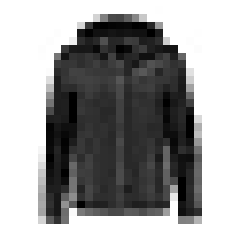

In [16]:
plt.imshow(X_train[0], cmap='binary')
plt.axis('off')
plt.show()

The labels are the class id's (as uint8), from 0-9

In [17]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are some corresponding class names:

In [18]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [19]:
class_names[y_train[0]]

'Coat'

In [20]:
X_valid.shape

(5000, 28, 28)

In [21]:
X_test.shape

(10000, 28, 28)

Saving figure fashion_mnist_plot


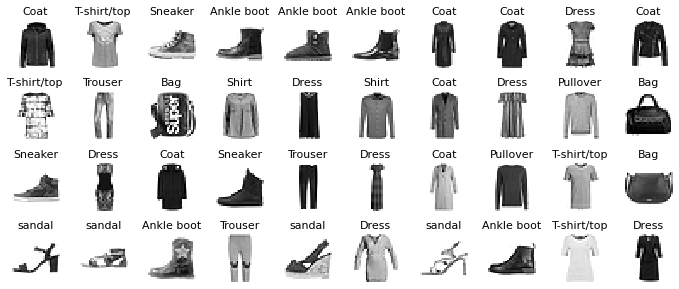

In [22]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=11)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

In [23]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

In [24]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [25]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [26]:
model.layers

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [31]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [38]:
hidden2 = model.layers[2]
hidden2.name

'dense_1'

In [39]:
model.get_layer(hidden2.name) is hidden2

True

In [40]:
weights, biases = hidden2.get_weights()

In [41]:
weights

array([[ 0.04602376, -0.0038019 ,  0.10557164, ...,  0.05382182,
        -0.09810888,  0.10975555],
       [-0.0131605 , -0.0401491 , -0.01301397, ..., -0.06764732,
        -0.05142808, -0.10832162],
       [ 0.0748878 ,  0.11689269,  0.06693598, ...,  0.04704887,
        -0.04119989,  0.1031863 ],
       ...,
       [-0.08606555,  0.1186113 , -0.11932244, ...,  0.1080649 ,
        -0.10135629,  0.05048553],
       [-0.1144025 , -0.06622341,  0.00440084, ..., -0.00439373,
         0.01447021,  0.02337808],
       [-0.10965011,  0.05632766,  0.11904002, ..., -0.0713827 ,
         0.11915682, -0.10558839]], dtype=float32)

In [42]:
weights.shape

(300, 100)

In [46]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [43]:
biases.shape

(100,)

In [44]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='sgd',
             metrics=['accuracy'])

This is equivalent to:

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

In [45]:
history = model.fit(X_train, y_train, epochs=30,
                   validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 6s 3ms/step - loss: 1.0188 - accuracy: 0.6805 - val_loss: 0.5219 - val_accuracy: 0.8206
Epoch 2/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5027 - accuracy: 0.8262 - val_loss: 0.4352 - val_accuracy: 0.8524
Epoch 3/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4482 - accuracy: 0.8419 - val_loss: 0.5358 - val_accuracy: 0.7984
Epoch 4/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4206 - accuracy: 0.8528 - val_loss: 0.3923 - val_accuracy: 0.8650
Epoch 5/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4059 - accuracy: 0.8577 - val_loss: 0.3747 - val_accuracy: 0.8690
Epoch 6/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3753 - accuracy: 0.8678 - val_loss: 0.3718 - val_accuracy: 0.8718
Epoch 7/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3653 - accuracy: 0.8703 - val_loss: 0.3622 - val_accuracy: